In [ ]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

import riiideducation

In [ ]:
# You can only call make_env() once, so don't lose it!
env = riiideducation.make_env()

In [ ]:
train_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv', low_memory=False, nrows=10**5, 
                       dtype={'row_id': 'int64', 'timestamp': 'int64', 'user_id': 'int32', 'content_id': 'int16', 'content_type_id': 'int8',
                              'task_container_id': 'int16', 'user_answer': 'int8', 'answered_correctly': 'int8', 'prior_question_elapsed_time': 'float32', 
                             'prior_question_had_explanation': 'boolean',
                             }
                      )
train_df = train_df.query('answered_correctly != -1').reset_index(drop=True)
train_df['prior_question_had_explanation'] = train_df['prior_question_had_explanation'].astype(float)

In [ ]:
train_df.head()

In [ ]:
y_train = train_df['answered_correctly']
X_train = train_df.drop(['answered_correctly', 'user_answer'], axis=1)

Light GBM is a gradient boosting framework that uses tree based learning algorithm.
Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.
Below diagrams explain the implementation of LightGBM and other boosting algorithms.
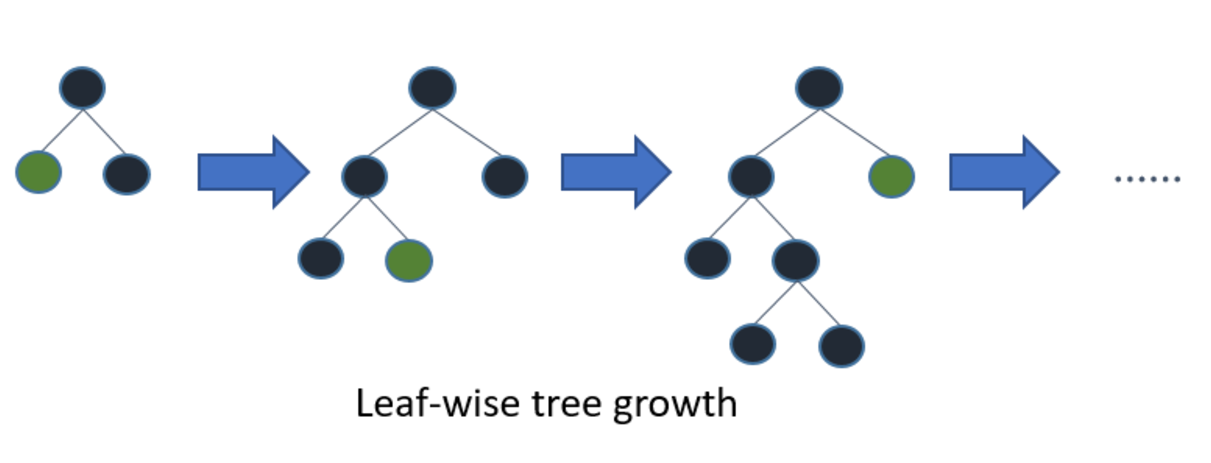


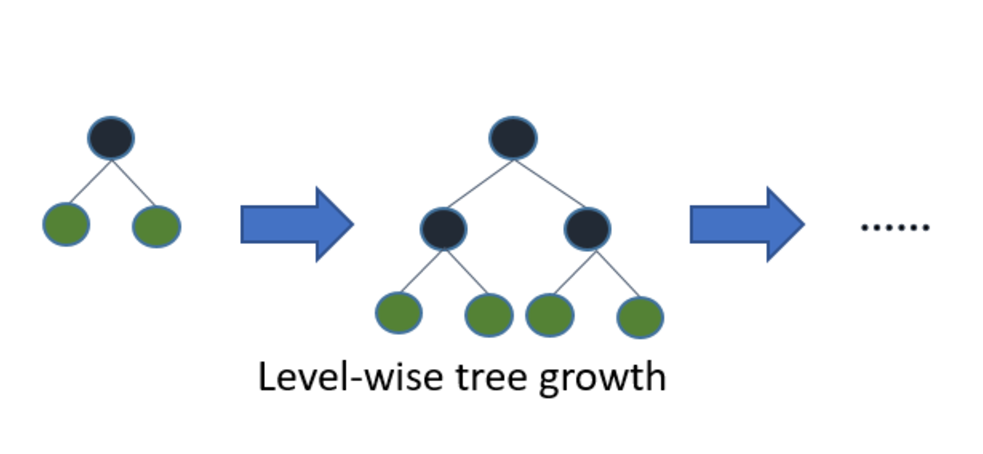


Why Light GBM is gaining extreme popularity?
The size of data is increasing day by day and it is becoming difficult for traditional data science algorithms to give faster results. Light GBM is prefixed as ‘Light’ because of its high speed. Light GBM can handle the large size of data and takes lower memory to run. Another reason of why Light GBM is popular is because it focuses on accuracy of results. LGBM also supports GPU learning and thus data scientists are widely using LGBM for data science application development.

Can we use Light GBM everywhere?
No, it is not advisable to use LGBM on small datasets. Light GBM is sensitive to overfitting and can easily overfit small data. Their is no threshold on the number of rows but my experience suggests me to use it only for data with 10,000+ rows.

We briefly discussed the concept of Light GBM, now what about it’s implementation?
Implementation of Light GBM is easy, the only complicated thing is parameter tuning. Light GBM covers more than 100 parameters but don’t worry, you don’t need to learn all.
It is very important for an implementer to know atleast some basic parameters of Light GBM. If you carefully go through following parameters of LGBM, I bet you will find this powerful algorithm a piece of cake.

Parameters
Control Parameters
max_depth: It describes the maximum depth of tree. This parameter is used to handle model overfitting. Any time you feel that your model is overfitted, my first advice will be to lower max_depth.
min_data_in_leaf: It is the minimum number of the records a leaf may have. The default value is 20, optimum value. It is also used to deal over fitting
feature_fraction: Used when your boosting(discussed later) is random forest. 0.8 feature fraction means LightGBM will select 80% of parameters randomly in each iteration for building trees.
bagging_fraction: specifies the fraction of data to be used for each iteration and is generally used to speed up the training and avoid overfitting.
early_stopping_round: This parameter can help you speed up your analysis. Model will stop training if one metric of one validation data doesn’t improve in last early_stopping_round rounds. This will reduce excessive iterations.
lambda: lambda specifies regularization. Typical value ranges from 0 to 1.
min_gain_to_split: This parameter will describe the minimum gain to make a split. It can used to control number of useful splits in tree.
max_cat_group: When the number of category is large, finding the split point on it is easily over-fitting. So LightGBM merges them into ‘max_cat_group’ groups, and finds the split points on the group boundaries, default:64
Core Parameters
Task: It specifies the task you want to perform on data. It may be either train or predict.
application: This is the most important parameter and specifies the application of your model, whether it is a regression problem or classification problem. LightGBM will by default consider model as a regression model.
regression: for regression
binary: for binary classification
multiclass: for multiclass classification problem
boosting: defines the type of algorithm you want to run, default=gdbt
gbdt: traditional Gradient Boosting Decision Tree
rf: random forest
dart: Dropouts meet Multiple Additive Regression Trees
goss: Gradient-based One-Side Sampling
num_boost_round: Number of boosting iterations, typically 100+
learning_rate: This determines the impact of each tree on the final outcome. GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates. Typical values: 0.1, 0.001, 0.003…
num_leaves: number of leaves in full tree, default: 31
device: default: cpu, can also pass gpu
Metric parameter
metric: again one of the important parameter as it specifies loss for model building. Below are few general losses for regression and classification.
mae: mean absolute error
mse: mean squared error
binary_logloss: loss for binary classification
multi_logloss: loss for multi classification
IO parameter
max_bin: it denotes the maximum number of bin that feature value will bucket in.
categorical_feature: It denotes the index of categorical features. If categorical_features=0,1,2 then column 0, column 1 and column 2 are categorical variables.
ignore_column: same as categorical_features just instead of considering specific columns as categorical, it will completely ignore them.
save_binary: If you are really dealing with the memory size of your data file then specify this parameter as ‘True’. Specifying parameter true will save the dataset to binary file, this binary file will speed your data reading time for the next time.
Knowing and using above parameters will definitely help you implement the model. Remember I said that implementation of LightGBM is easy but parameter tuning is difficult. So let’s first start with implementation and then I will give idea about the parameter tuning.
Implementation
Installating LGBM:
Installing LightGBM is a crucial task. I found this as the best resource which will guide you in LightGBM installation.
I am using Anaconda and installing LightGBM on anaconda is a clinch. Just run the following command on your Anaconda command prompt and whoosh, LightGBM is on your PC.
conda install -c conda-forge lightgbm


In [ ]:
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = ['user_id', 'content_type_id', 'task_container_id', 'prior_question_had_explanation']

params = {
    'objective': 'binary',
    'max_bin': 300,
    'learning_rate': 0.05,
    'num_leaves': 40
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train, categorical_feature=categorical_features)

    model = lgb.train(
        params, lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        verbose_eval=10,
        num_boost_round=1000,
        early_stopping_rounds=10
    )

    oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    models.append(model)

In [ ]:
roc_auc_score(y_train, oof_train)

In [ ]:
iter_test = env.iter_test()

In [ ]:
for (test_df, sample_prediction_df) in iter_test:
    y_preds = []
    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].astype(float)
    X_test = test_df.drop(['prior_group_answers_correct', 'prior_group_responses'], axis=1)

    for model in models:
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_preds.append(y_pred)

    y_preds = sum(y_preds) / len(y_preds)
    test_df['answered_correctly'] = y_preds
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])